# Overview

These sections match the marking scheme. Each heading indicates the marks for each and type of content that should be included (either Markdown or Code). You can prepare markdown sections  in Microsoft Word, but remember to change the cell type to 'Markdown' so the cell is not executed as code. (See: <a href="https://www.markdownguide.org/basic-syntax/">Markdown<a/>)

1. Rename the Notebook replacing the words '_KF7032_Template_' with your user id (something like w12345678_KF7032)
2. Before you submit the final version of your notebook, you should delete all output, and then run all cells. This checks that your program is consistent.
3. Finally download the notebooks as an __.ipynb file__ for assessment, and also as an __html file__ that will readable by examiners who do not have Jupyter.
4. Sections identified as Markdown should be at least one paragraph of text. The total word limit for markdown is 2500 words

# 1) Introduction: The Crime Analysis task ..._Markdown_, **10 Marks**, Max 300 Words

This section should be written in markdown.

 # 1) Introduction

This project's Crime Analysis task seeks to delve into how the frequency of various crime types in Vancouver, Canada has been influenced by the COVID-19 pandemic. The impetus for this exploration comes from significant academic research investigating the intricate connection between the pandemic and crime rates.

(Hodgkinson & Andresen, 2020) conducted a comprehensive investigation, analyzing various crime categories, including residential burglary, commercial burglary, violence, and mischief. Through the utilization of interrupted time series techniques, this research provides valuable insights into the consequences faced by different types of crimes at the city level amid the COVID-19 pandemic.

Additionally, (Nivette AE, 2021) conducted a comprehensive study, collecting data on daily crime counts in 27 cities across 23 countries. The findings revealed a substantial decrease in urban crime associated with stay-at-home policies, albeit with notable variations across cities and crime types. Remarkably, the study identified an increase in online crime rates amid declining rates of violent and property crimes following the first lockdown.

Addressing research gaps, (Buil-Gil D, 2021) applied interrupted time-series analysis to scrutinize the effects of three lockdown orders in Northern Ireland on both offline and online crime. This study contributes to understanding potentially divergent trends in these crime types, presenting a more holistic view of the repercussions of lockdown measures.


In this undertaking, our goal is to base the groundwork established by (Hodgkinson & Andresen, 2020), (Nivette AE, 2021), and (Buil-Gil D, 2021). Our primary aim is to uncover the relation between the COVID-19 pandemic and Violent crime rates in the United Kingdom. This encompasses filtering and preprocessing crime data, visualizing trends, and implementing statistical and machine learning models for a detailed analysis. The ultimate goal is to provide insights that can assist an insurance company in understanding and mitigating risks associated with changing crime patterns during the pandemic.

# 2) Component Selection and Data Pipeline Implementation _code_	**10 Marks**

In this section you will have one or more code cells. These will include your library imports. You will also access the data efficiently using Apache Spark on a cloud Infrastructure as a Service (IaaS) platform. (NB Google colab is SaaS -- not IaaS)

To speed your subsequent development you may want to initially use a subset of the data so could process that here.

In [1]:
# Step 1: Importing Libraries
import warnings
import itertools
import numpy as np
import pandas as pd
from pyspark import SparkFiles
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import count, col, to_date, expr

import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import seaborn as sns; sns.set_theme()


from pyspark.sql.functions import year, month

In [2]:
spark = SparkSession.builder.appName('Crime Analysis').getOrCreate()

# 3) Data Extraction and Filtering ... _code_, 10 Marks
### includes System running, test and diagnostics, 

1.	Filter the dataset so that crimes refer to appropriate crimes only
2.  To see whether crime cartegories are increasing, you will also need to extract them as a time series.

You should be using diagnostic checks throughout this report.

1. Reading and Preprocessing Crime Data

This section reads the crime data from a CSV file into a Spark DataFrame.

In [3]:
# Step 3: Reading Crime Data
df_all_crime = spark.read.csv("all_crimes21_hdr.txt.gz", header=True, inferSchema=True)

In [4]:
# Data Integrity Checks
print("Data Integrity Checks:")
print("Total Rows in Crime Data:", df_all_crime.count())


Data Integrity Checks:
Total Rows in Crime Data: 65078250


In [5]:
# Consistency Checks
print("\nConsistency Checks:")
print("Columns in Crime Data:", df_all_crime.columns)
print("Data Types in Crime Data:")
df_all_crime.printSchema()


Consistency Checks:
Columns in Crime Data: ['Crime ID', 'Month', 'Reported by', 'Falls within', 'Longitude', 'Latitude', 'Location', 'LSOA code', 'LSOA name', 'Crime type', 'Last outcome category', 'Context']
Data Types in Crime Data:
root
 |-- Crime ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported by: string (nullable = true)
 |-- Falls within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA code: string (nullable = true)
 |-- LSOA name: string (nullable = true)
 |-- Crime type: string (nullable = true)
 |-- Last outcome category: string (nullable = true)
 |-- Context: string (nullable = true)



In [6]:
# Statistical Checks
print("\nStatistical Checks:")
df_all_crime.describe().show()


Statistical Checks:
+-------+--------------------+--------+--------------------+--------------------+-------------------+-----------------+--------------------+---------+---------+--------------------+---------------------+--------------------+
|summary|            Crime ID|   Month|         Reported by|        Falls within|          Longitude|         Latitude|            Location|LSOA code|LSOA name|          Crime type|Last outcome category|             Context|
+-------+--------------------+--------+--------------------+--------------------+-------------------+-----------------+--------------------+---------+---------+--------------------+---------------------+--------------------+
|  count|            40835915|65078250|            65078250|            65078250|           64120803|         64120803|            65078250| 62549985| 62549985|            65078250|             38660118|              122405|
|   mean|                null|    null|                null|                nul

In [7]:
print("Columns in df_all_crime:", df_all_crime.columns)


Columns in df_all_crime: ['Crime ID', 'Month', 'Reported by', 'Falls within', 'Longitude', 'Latitude', 'Location', 'LSOA code', 'LSOA name', 'Crime type', 'Last outcome category', 'Context']


The following sections renames columns for clarity, converts the 'Month' column to a date format, filters data before April 2020, and displays the preprocessed data.

In [8]:
df = df_all_crime.withColumnRenamed('Crime ID', 'Crime_ID') \
    .withColumnRenamed('Falls within', 'Falls_within') \
    .withColumnRenamed('LSOA code', 'LSOA_code') \
    .withColumnRenamed('LSOA name', 'LSOA_name') \
    .withColumnRenamed('Crime type', 'Crime_type') \
    .withColumnRenamed('Last outcome category', 'Last_outcome_category')

In [9]:
# Step 4: Preprocessing Crime Data
df_all_crime = df_all_crime.withColumnRenamed('Crime ID', 'Crime_ID') \
    .withColumnRenamed('Falls within', 'Falls_within') \
    .withColumnRenamed('LSOA code', 'LSOA_code') \
    .withColumnRenamed('LSOA name', 'LSOA_name') \
    .withColumnRenamed('Crime type', 'Crime_type') \
    .withColumnRenamed('Last outcome category', 'Last_outcome_category')

# Extracting Month
df_all_crime = df_all_crime.withColumn('Month', to_date(col('Month'), 'yyyy-MM'))

# Filtering Data Based on Date Criteria (Before April 2020)
df_all_crime = df_all_crime.filter(col('Month') < "2020-04-01") \
    .orderBy('Month')




In [10]:
# Display the preprocessed data
df_all_crime.show()

+--------+----------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
|Crime_ID|     Month|         Reported by|        Falls_within|Longitude| Latitude|            Location|LSOA_code|           LSOA_name|          Crime_type|Last_outcome_category|Context|
+--------+----------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
|    null|2010-12-01|Avon and Somerset...|Avon and Somerset...|  -0.8056|51.819143|On or near Norfol...|E01017662| Aylesbury Vale 015C|         Other crime|                 null|   null|
|    null|2010-12-01|Avon and Somerset...|Avon and Somerset...|-2.494366|51.418169|On or near Keynsh...|E01014399|Bath and North Ea...|Anti-social behav...|                 null|   null|
|    null|2010-12-01|Avon and Somerset...|Avon and Somerset...|-2

2. Reading LSOA Population Data

In [11]:
# Step 5: Reading LSOA Population Data
df_lsoa = spark.read.csv("LSOA_pop_v2.csv", header=True, inferSchema=True)
df_lsoa = df_lsoa.select([col(column).alias(column.replace(' ', '_'))
                                    for column in df_lsoa.columns])

This part reads LSOA (Lower Layer Super Output Area) population data from a CSV file, renames columns by replacing spaces with underscores, and prepares the DataFrame for further analysis.

3. Filtering and Grouping Violent Crimes

In [12]:
# Step 6: Filtering and Grouping Violent Crimes
df_violent_crimes = df_all_crime.filter(
    col('Crime_type').isin({'Violent crime', 'Violence and sexual offences'})
).groupBy('Month').count().orderBy('Month')

In [13]:
# Step 7: Converting to Pandas for Visualization
pdf_violent_crimes = df_violent_crimes.toPandas()
pdf_violent_crimes.Month = pdf_violent_crimes.Month.astype('datetime64[ns]')
pdf_violent_crimes = pdf_violent_crimes.set_index(pd.to_datetime(pdf_violent_crimes.Month))


# 4) Design, Development and reasoning behind use of multiple visualization methods, statistics, and machine learning Models,  _markdown_, _code_,  _markdown_, 20 Marks

The purpose of visualizations is to help identify relationships to investigate more formally, such as with statistics. Consequently you must explain your design choices. That is, what are you expecting to see in your graphics. Support your ideas using the literature.

_your work here_

4. Visualizing Violent Crime Time Series

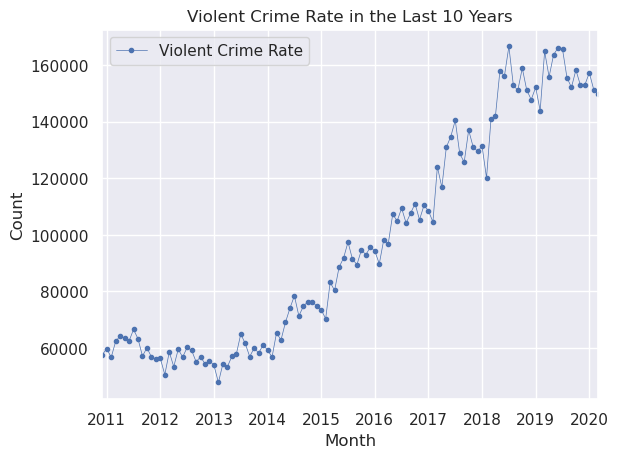

In [14]:
# Step 8: Plotting Violent Crime Time Series
pdf_violent_crimes.plot(y='count', x='Month', marker='.', linestyle='-', linewidth=0.5, subplots=False,
                        label='Violent Crime Rate', title='Violent Crime Rate in the Last 10 Years')
plt.ylabel('Count')
plt.show()


This section generates a line plot to visualize the time series of violent crime rates over the last years, providing an initial overview of trends.

5. Time Series Decomposition

In [15]:

# Step 9: Time Series Decomposition
decomposition = sm.tsa.seasonal_decompose(pdf_violent_crimes['count'], model='additive', extrapolate_trend='freq')

The code decomposes the time series into trend, seasonal, and residual components using the seasonal decomposition of time series (STL) method. Subsequently, it sets up the plot for the decomposed components.

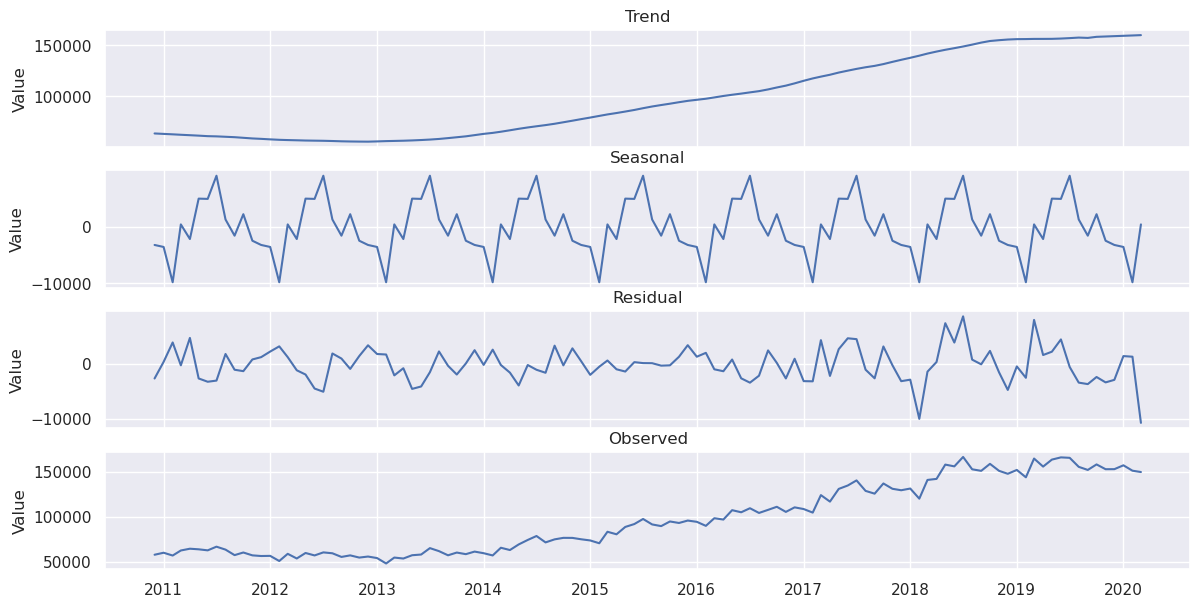

In [16]:
# Step 10: Plotting Decomposed Components
# (Code for plotting trend, seasonal, residual, and observed components)


# Plot the decomposed components
f, ax = plt.subplots(4, 1, sharex=True)
f.set_size_inches(14, 7)

ax[0].plot(pdf_violent_crimes['Month'], decomposition.trend, 'b')
ax[0].set_title('Trend')
ax[0].set_ylabel('Value')

ax[1].plot(pdf_violent_crimes['Month'], decomposition.seasonal, 'b')
ax[1].set_title('Seasonal')
ax[1].set_ylabel('Value')

ax[2].plot(pdf_violent_crimes['Month'], decomposition.resid, 'b')
ax[2].set_title('Residual')
ax[2].set_ylabel('Value')

ax[3].plot(pdf_violent_crimes['Month'], decomposition.observed, 'b')
ax[3].set_title('Observed')
ax[3].set_ylabel('Value')

plt.show()


6. Visual Inspection and Stationarity Test

In [17]:
def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print(f"\t{k}: {v} - The data is {'not ' if v < dftest[0] else ''}stationary with {100-int(k[:-1])}% confidence")

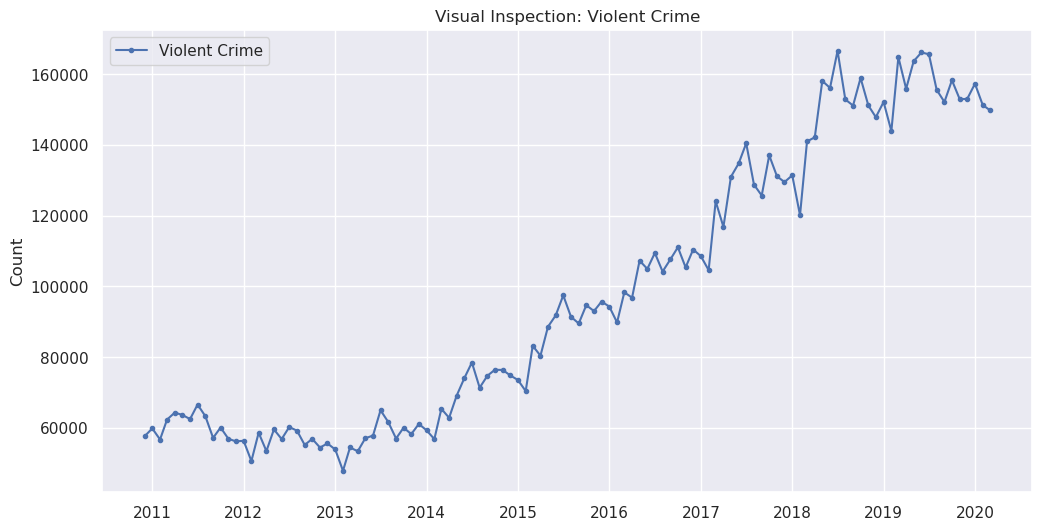

 > Is the Violent Crime stationary ?
Test statistic = -1.794
P-value = 0.384
Critical values :
	1%: -3.4989097606014496 - The data is not stationary with 99% confidence
	5%: -2.891516256916761 - The data is not stationary with 95% confidence
	10%: -2.5827604414827157 - The data is not stationary with 90% confidence


In [18]:
# Step 11: Visual Inspection and Stationarity Test
def visualize_and_test_stationarity(timeseries, title):
    # Visual inspection
    plt.figure(figsize=(12, 6))
    plt.plot(timeseries, label=title, marker='.')
    plt.title('Visual Inspection: ' + title)
    plt.ylabel('Count')
    plt.legend()
    plt.show()

    # Stationarity test
    ADF_test(timeseries, title)

# Step 12: Applying Visual Inspection and Stationarity Test
visualize_and_test_stationarity(pdf_violent_crimes['count'], 'Violent Crime')




This calls a function to visually inspect the time series and perform an Augmented Dickey Fuller (ADF) test to check for stationarity.

<Figure size 640x480 with 0 Axes>

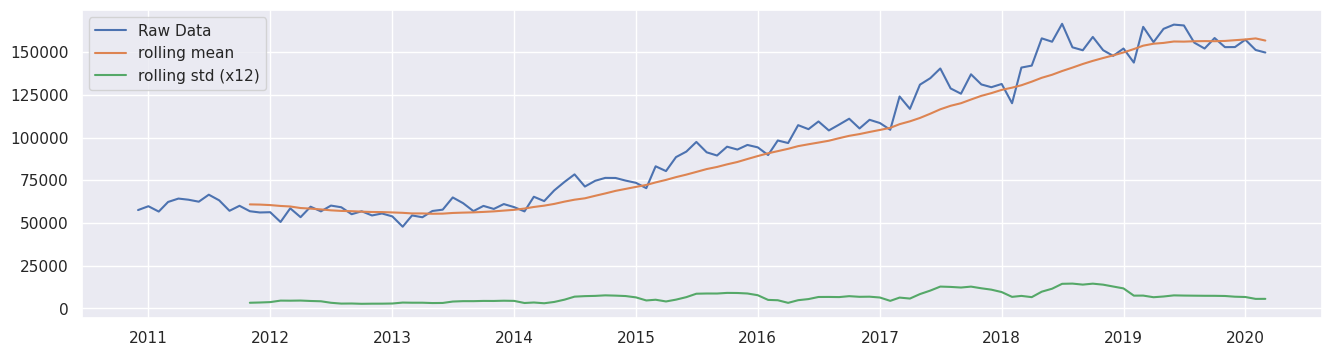

 > Is the Raw Data stationary?
Test statistic = -1.794
P-value = 0.384
Critical values:
	1%: -3.4989097606014496 - The data is not stationary with 99% confidence
	5%: -2.891516256916761 - The data is not stationary with 95% confidence
	10%: -2.5827604414827157 - The data is not stationary with 90% confidence


In [19]:
# Function to test stationarity
def test_stationarity(timeseries, title):
    plt.clf()
    # Determining rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    rolstd = pd.Series(timeseries).rolling(window=12).std()

    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label=title)
    ax.plot(rolmean, label='rolling mean')
    ax.plot(rolstd, label='rolling std (x12)')
    ax.legend()
    plt.show()

pd.options.display.float_format = '{:.8f}'.format
test_stationarity(pdf_violent_crimes['count'], 'Raw Data')

# Augmented Dickey Fuller (ADF) test
no = 'not'
def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values:')
    for k, v in dftest[4].items():
        print(f"\t{k}: {v} - The data is {no if v < dftest[0] else ''} stationary with {100-int(k[:-1])}% confidence")

ADF_test(pdf_violent_crimes['count'], 'Raw Data')



In [20]:
# Detrending
count = pdf_violent_crimes['count']
count_detrend = (count - count.rolling(window=12).mean()) / count.rolling(window=12).std()

ADF_test(count_detrend, 'Detrended Data')



 > Is the Detrended Data stationary?
Test statistic = -1.051
P-value = 0.734
Critical values:
	1%: -3.506944401824286 - The data is not stationary with 99% confidence
	5%: -2.894989819214876 - The data is not stationary with 95% confidence
	10%: -2.584614550619835 - The data is not stationary with 90% confidence


<Figure size 640x480 with 0 Axes>

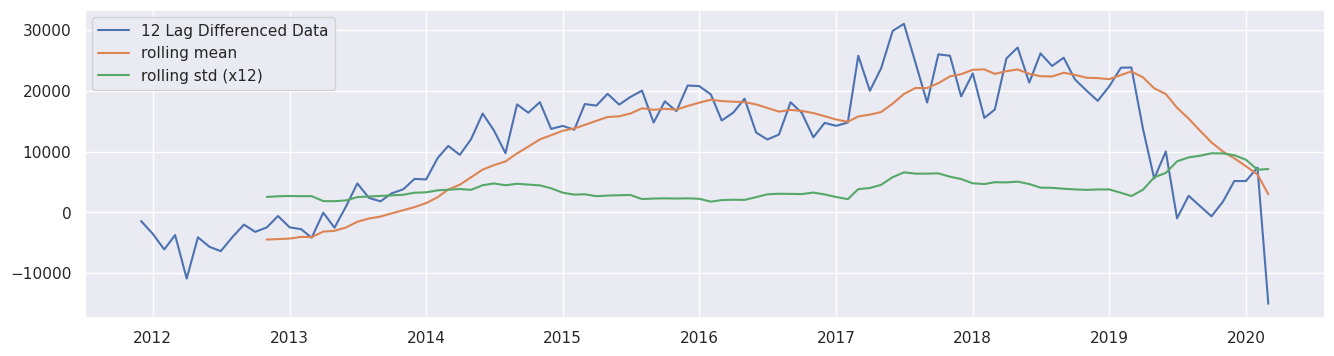

 > Is the 12 Lag Differenced Data stationary?
Test statistic = -1.406
P-value = 0.579
Critical values:
	1%: -3.5078527246648834 - The data is not stationary with 99% confidence
	5%: -2.895382030636155 - The data is not stationary with 95% confidence
	10%: -2.584823877658872 - The data is not stationary with 90% confidence


In [21]:
# Differencing
y_12lag = count - count.shift(12)

test_stationarity(y_12lag, '12 Lag Differenced Data')
ADF_test(y_12lag, '12 Lag Differenced Data')



<Figure size 640x480 with 0 Axes>

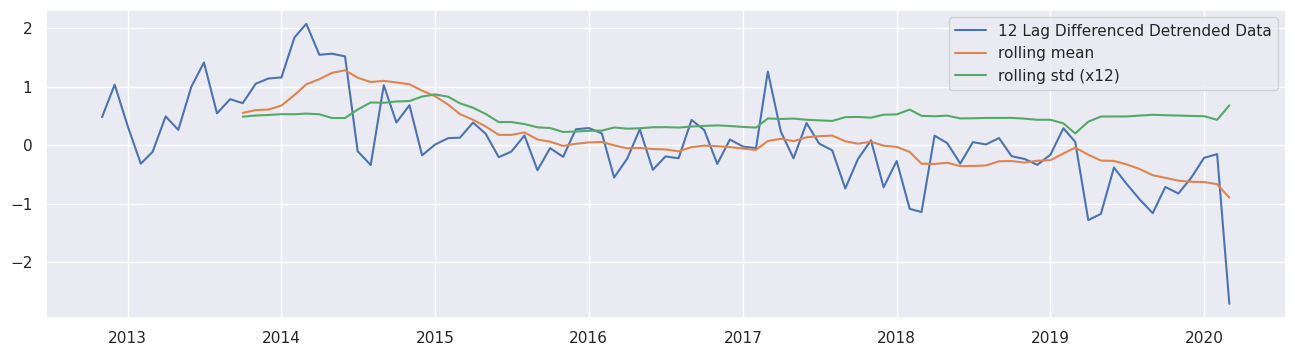

 > Is the 12 Lag Differenced Detrended Data stationary?
Test statistic = -1.575
P-value = 0.496
Critical values:
	1%: -3.5087828609430614 - The data is not stationary with 99% confidence
	5%: -2.895783561573195 - The data is not stationary with 95% confidence
	10%: -2.5850381719848565 - The data is not stationary with 90% confidence


In [22]:
# Detrending + Differencing
y_12lag_detrend = count_detrend - count_detrend.shift(12)

test_stationarity(y_12lag_detrend, '12 Lag Differenced Detrended Data')
ADF_test(y_12lag_detrend, '12 Lag Differenced Detrended Data')



In [23]:

# Step 14: Violent Crime Analysis
df_violent_crimes_specific = df_all_crime.filter(col('Crime_type').isin({'Violent crime', 'Violence and sexual offences'})) \
    .withColumn('city', expr("substring(LSOA_name, 1, length(LSOA_name)-5)")) \
    .groupBy('city').count().withColumnRenamed('count', 'crime_count')

# Joining on 'city' and 'geography_code' columns
per_head_violent_crimes = df_violent_crimes_specific.join(df_lsoa, col('city') == col('geography_code'), 'left_outer') \
    .select( 'city', 'crime_count')

# Show results
per_head_violent_crimes.show()

+--------------------+-----------+
|                city|crime_count|
+--------------------+-----------+
|           Worcester|      24816|
|           Charnwood|      23107|
|      North Kesteven|       8819|
|                Arun|      25032|
|       Epping Forest|      20447|
|             Waveney|      23576|
|              Stroud|       9864|
|           Sedgemoor|      21106|
|              Maldon|       7707|
|          New Forest|      20114|
|           Guildford|      19908|
|            Worthing|      20362|
|             Fareham|      12445|
|Central Bedfordshire|      30038|
|              Bolton|      57149|
|      North Tyneside|      35460|
|        Surrey Heath|      10727|
|      Wellingborough|      15374|
|              Slough|      31632|
|          Spelthorne|      15492|
+--------------------+-----------+
only showing top 20 rows



7. SARIMA Time Series Analysis

 > Is the count stationary?
Test statistic = -1.051
P-value = 0.734
Critical values:
	1%: -3.506944401824286 - The data is not stationary with 99% confidence
	5%: -2.894989819214876 - The data is not stationary with 95% confidence
	10%: -2.584614550619835 - The data is not stationary with 90% confidence


<Figure size 640x480 with 0 Axes>

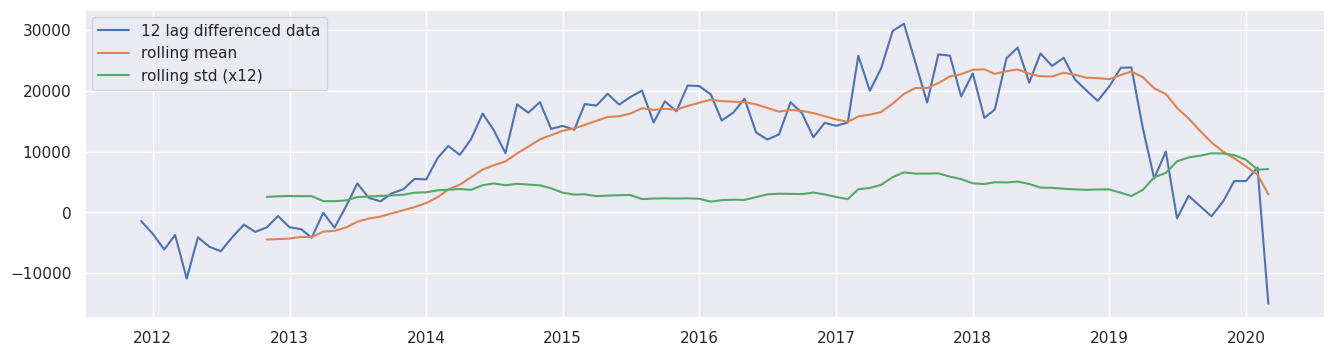

 > Is the 12 lag differenced data stationary?
Test statistic = -1.406
P-value = 0.579
Critical values:
	1%: -3.5078527246648834 - The data is not stationary with 99% confidence
	5%: -2.895382030636155 - The data is not stationary with 95% confidence
	10%: -2.584823877658872 - The data is not stationary with 90% confidence


<Figure size 640x480 with 0 Axes>

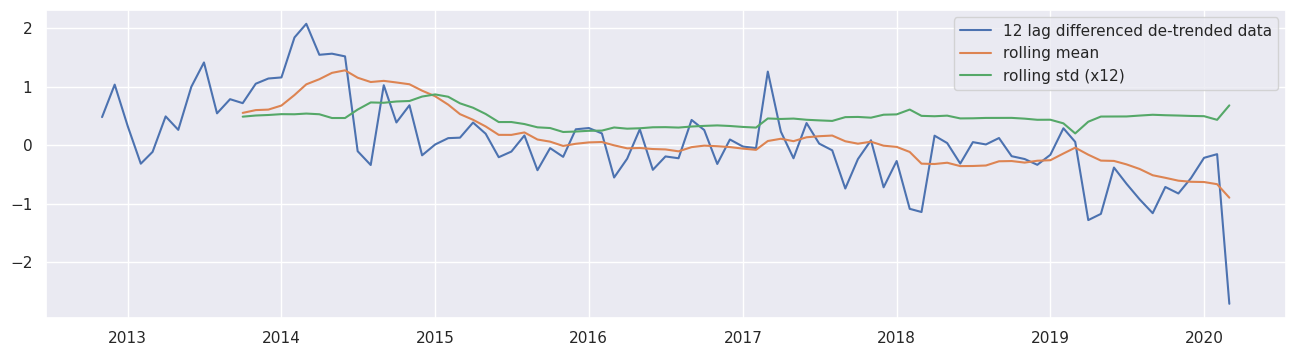

 > Is the 12 lag differenced de-trended data stationary?
Test statistic = -1.575
P-value = 0.496
Critical values:
	1%: -3.5087828609430614 - The data is not stationary with 99% confidence
	5%: -2.895783561573195 - The data is not stationary with 95% confidence
	10%: -2.5850381719848565 - The data is not stationary with 90% confidence


In [24]:



# SARIMA Time Series Analysis
# Assuming `pdf_violent_crimes` is the correct DataFrame for crime count
count = pdf_violent_crimes['count']
count_detrend =  (count - count.rolling(window=12).mean())/count.rolling(window=12).std()

ADF_test(count_detrend, 'count')

y_12lag = count - count.shift(12)
test_stationarity(y_12lag, '12 lag differenced data')
ADF_test(y_12lag, '12 lag differenced data')

y_12lag_detrend = count_detrend - count_detrend.shift(12)
test_stationarity(y_12lag_detrend, '12 lag differenced de-trended data')
ADF_test(y_12lag_detrend, '12 lag differenced de-trended data')





This section involves the training and fitting of a Seasonal Autoregressive Integrated Moving Average (SARIMA) model to the time series data.

In [25]:
y = y_12lag_detrend.dropna()

In [26]:
# Model Training and Fitting
y_to_train = y[:'2020-04-01']  
y_to_test = y['2020-04-01':'2021-12-01']
y_to_val = y_to_test

warnings.filterwarnings("ignore")

p = d = q = range(0, 2)
seasonal_period = 12
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], seasonal_period) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_to_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_invertibility=False)
            results = mod.fit()
        except Exception as ex:
            continue

order = (0, 0, 1)  # Using Values from the previous step
seasonal_order = (1, 1, 1, 12)
model = sm.tsa.statespace.SARIMAX(y_to_train,
                                  order=order,
                                  seasonal_order=seasonal_order,
                                  enforce_invertibility=False)
results = model.fit()



8. Forecast Plotting

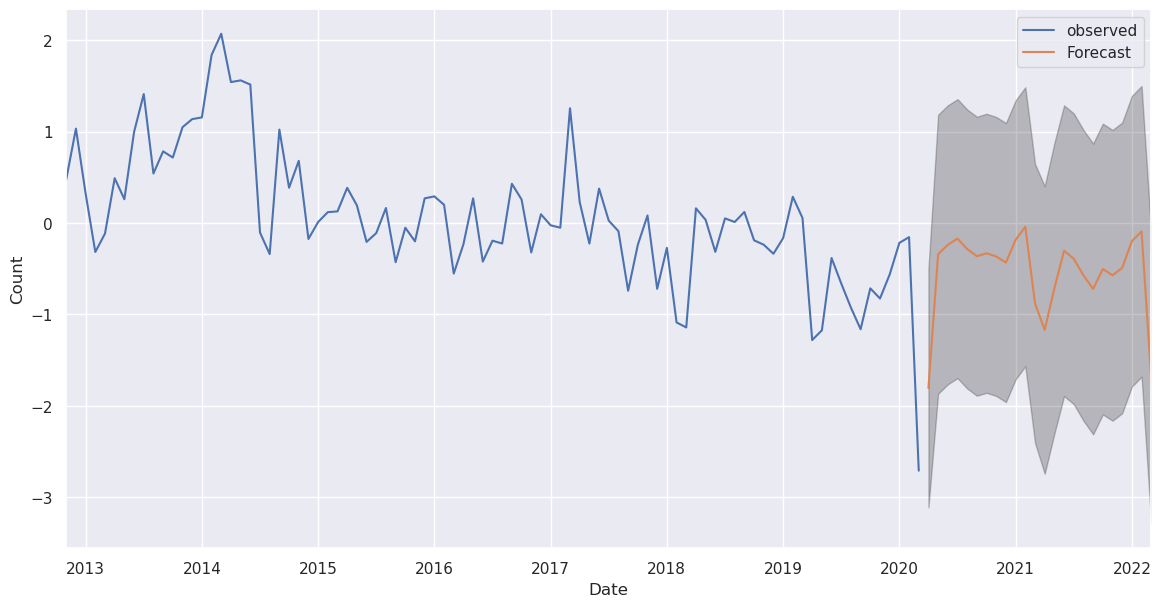

In [27]:
# Forecast Plotting
pred_uc = results.get_forecast(steps=24)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(14, 7))

pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Count')

plt.legend()
plt.show()


This part generates plots to visualize the forecasted values of violent crime rates along with confidence intervals.

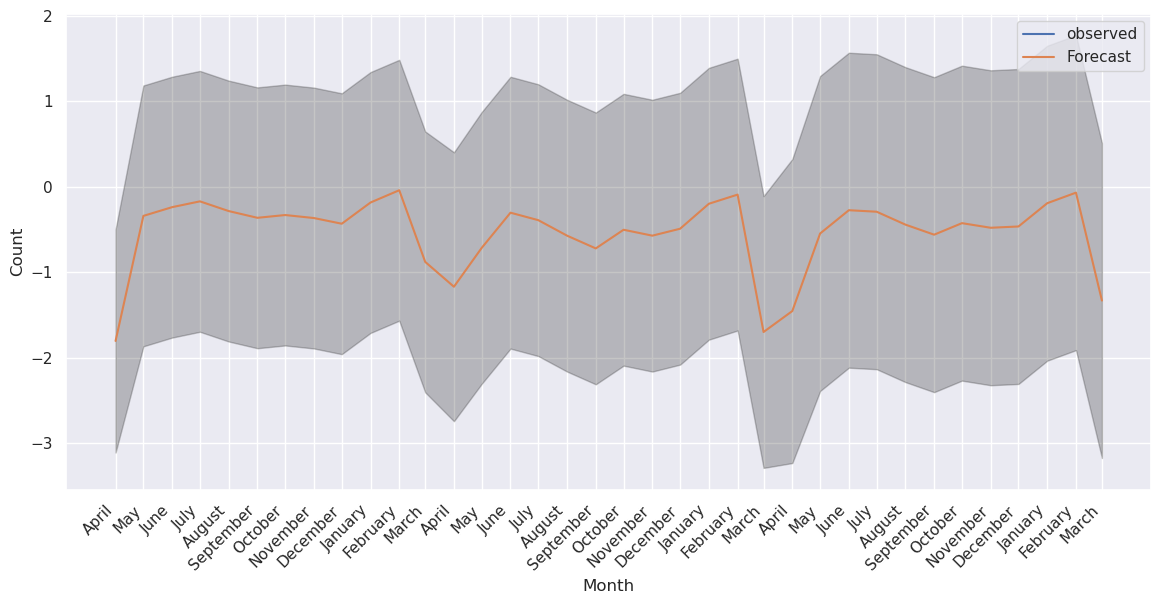

In [28]:
# Forecast Plotting with extension till December 2021
forecast_end_date = '2021-12-31'

# Forecast Plotting with extension till December 2021
forecast_steps = 36  # Adjust the number of forecast steps as needed
pred_uc = results.get_forecast(steps=forecast_steps)
pred_ci = pred_uc.conf_int()

# Filter data for the desired time period
start_date = '2020-04-01'
end_date = '2021-12-31'
y_observed = y[start_date:end_date]

ax = y_observed.plot(label='observed', figsize=(14, 7))

pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

# Add month labels to the x-axis
ax.set_xticks(pred_uc.predicted_mean.index)
ax.set_xticklabels([month.strftime('%B') for month in pred_uc.predicted_mean.index], rotation=45, ha='right')

ax.set_xlabel('Month')
ax.set_ylabel('Count')

plt.legend()
plt.show()


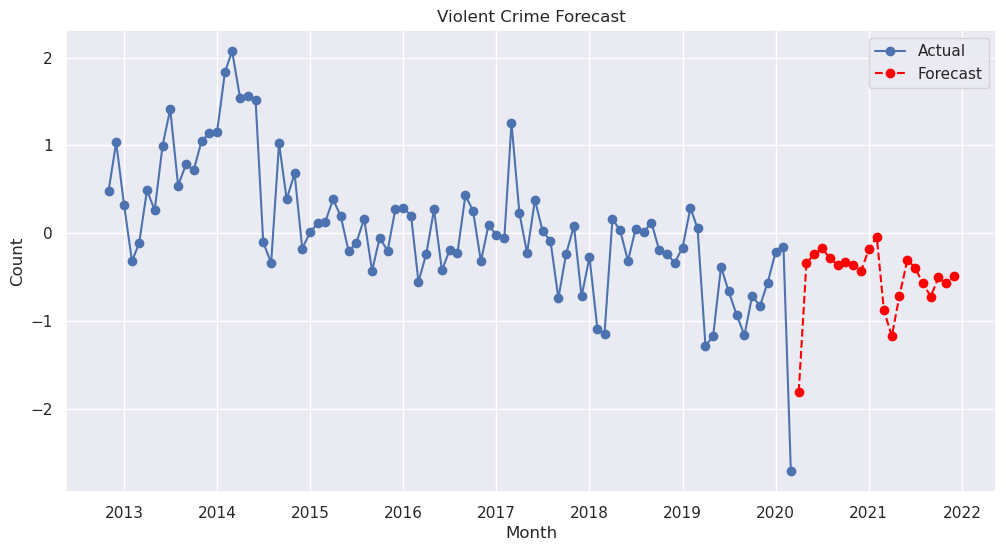

In [29]:
# Plotting the original time series and forecasted values
plt.figure(figsize=(12, 6))

# Plotting actual values
plt.plot(y.index, y, label='Actual', marker='o')

# Forecasting for April 2020
forecast_start = '2020-04-01'
forecast_end = '2021-12-01'
forecast = results.get_prediction(start=forecast_start, end=forecast_end, dynamic=True)

# Plotting forecasted values
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, label='Forecast', linestyle='dashed', color='red', marker='o')

plt.title('Violent Crime Forecast')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend()
plt.show()


In [62]:
df_violent_crimes_april = df.filter(
    (col('Crime type').isin({'Violent crime', 'Violence and sexual offences'})) &
    (col('Month') < '2020-04-01')
).groupBy('Month').count()




9. ARIMA Model

In [63]:
# Import ARIMA model
from statsmodels.tsa.arima.model import ARIMA

# Assuming 'count' is the correct column name
count_series = df_violent_crimes_april.toPandas()['count']

# Fit ARIMA model
model = ARIMA(count_series, order=(1, 1, 1))
fit_model = model.fit()


# Forecast violent crime levels for April 2020
forecast_april_2020 = fit_model.forecast(steps=1)
print(f"Forecast for April 2020: {forecast_april_2020.values[0]:.2f}")


Forecast for April 2020: 95037.03


Here, the code fits an ARIMA model to the time series data and forecasts violent crime levels for April 2020.

10. Filtering for Leicester Region

This section filters the DataFrame to focus on the Leicester region, specifically targeting violent crimes between July 2020 and December 2021. The resulting data is then visualized to observe the trends in violent crime rates for Leicester.

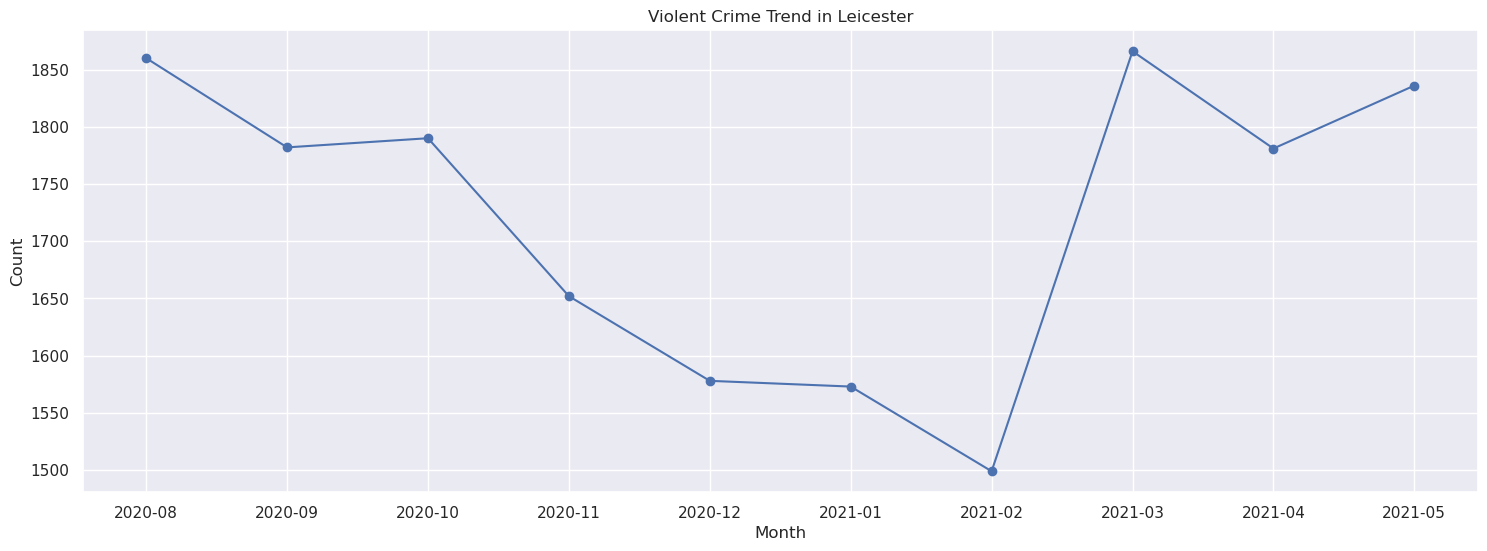

In [31]:
# Filtering for Leicester Region
df_leicester_crime = df.filter(
    (col('LSOA_name').contains('Leicester')) &
    (col('Crime type').isin({'Violent crime', 'Violence and sexual offences'})) &
    (col('Month') >= '2020-07-01') & (col('Month') <= '2021-12-31')&
    (col('Falls_within').contains('Leicester'))
)

# Visualizing trends for Leicester
pdf_leicester_crime = df_leicester_crime.groupby('Month').count().orderBy('Month').toPandas()

# Plotting the trend for Leicester
plt.figure(figsize=(18, 6))
plt.plot(pdf_leicester_crime['Month'], pdf_leicester_crime['count'], marker='o')
plt.title('Violent Crime Trend in Leicester')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()


In [40]:
# Filter data for the Leicester region and violent crimes

df_violent_crimes_leicester = df.filter(
    (col('LSOA_name').contains('Leicester')) &
    (col('Crime type').isin({'Violent crime', 'Violence and sexual offences'})) &
    (col('Month') < '2020-07-01') &
    (col('Falls_within').contains('Leicester'))
).groupBy('Month').count()

# Show the resulting DataFrame
df_violent_crimes_leicester.show()

+-------+-----+
|  Month|count|
+-------+-----+
|2020-06| 1596|
|2013-05|  580|
|2019-10| 1391|
|2018-10| 1381|
|2013-09|  534|
|2020-02| 1338|
|2017-09| 1149|
|2013-12|  587|
|2019-11| 1428|
|2013-06|  640|
|2017-10| 1172|
|2016-02|  705|
|2011-05|  698|
|2017-05| 1039|
|2018-06| 1420|
|2019-03| 1441|
|2015-05|  414|
|2017-11| 1182|
|2018-03| 1225|
|2012-08|  544|
+-------+-----+
only showing top 20 rows



In [43]:
from statsmodels.tsa.arima.model import ARIMA



# Convert 'count' column to a Pandas Series
leicester_series = df_violent_crimes_leicester.select('count').toPandas()['count']

# Fit ARIMA model for Leicester
leicester_model = ARIMA(leicester_series, order=(1, 1, 1))
leicester_fit_model = leicester_model.fit()

# Forecast violent crime levels for July 2020
forecast_july_2020 = leicester_fit_model.forecast(steps=1)
print(f"Forecast for July 2020 in Leicester: {forecast_july_2020.values[0]:.2f}")


Forecast for July 2020 in Leicester: 865.87


11. Monthly Trend Analysis for Violent Crimes

This section further analyzes the monthly trend of violent crimes. It extracts the month and year from the 'Month' column, groups the data by year and month, and calculates the sum of violent crimes. The results are converted to Pandas for plotting a line chart showing the monthly trend.

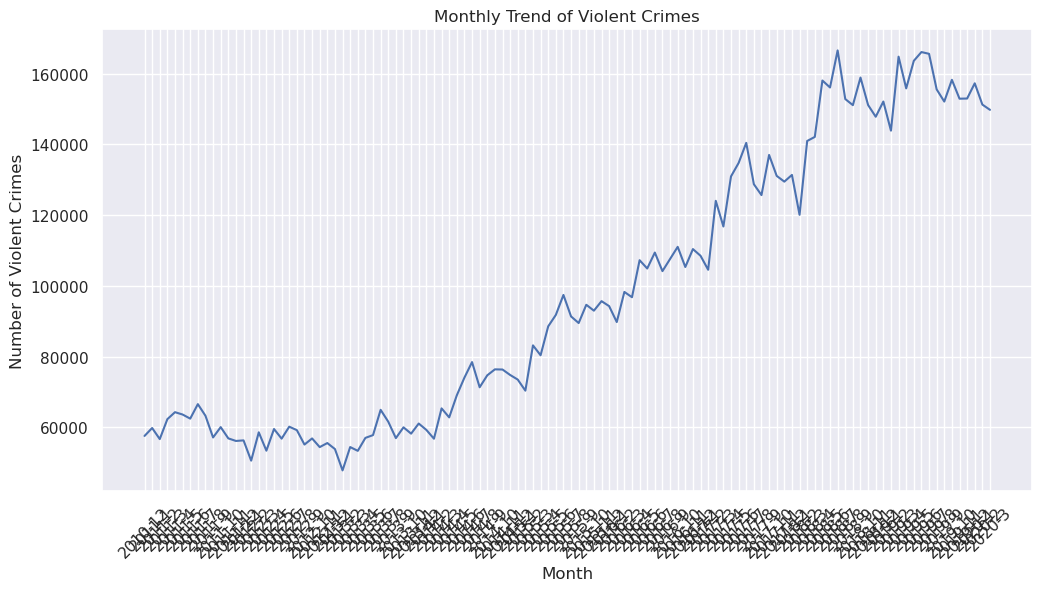

In [52]:

# Extract month and year from the 'Month' column
df_violent_crimes = df_violent_crimes.withColumn('Year', year('Month')).withColumn('Month', month('Month'))

# Group by Year and Month to get the count of violent crimes
monthly_trend = df_violent_crimes.groupBy('Year', 'Month').sum('count').orderBy('Year', 'Month')

# Convert to Pandas for plotting
monthly_trend_pd = monthly_trend.toPandas()

# Plotting the monthly trend
plt.figure(figsize=(12, 6))
plt.plot(monthly_trend_pd['Year'].astype(str) + '-' + monthly_trend_pd['Month'].astype(str), monthly_trend_pd['sum(count)'])
plt.title('Monthly Trend of Violent Crimes')
plt.xlabel('Month')
plt.ylabel('Number of Violent Crimes')
plt.xticks(rotation=45)
plt.show()

12. Additional Analysis - Firearms and Drugs

This part explores additional analyses on firearms and drugs. It filters the data for possession of weapons with offenders sent to prison, calculates the crime count per head for firearms, and visualizes the per-head values for selected cities. It also includes a pie chart for crime type distribution and additional analysis on drug-related crimes.

+--------------------+-----------+
|                city|crime_count|
+--------------------+-----------+
|           Worcester|         37|
|           Charnwood|         12|
|      North Kesteven|          4|
|       Epping Forest|          9|
|                Arun|         14|
|             Waveney|         14|
|              Stroud|          4|
|           Sedgemoor|         12|
|          New Forest|          5|
|              Maldon|          3|
|            Worthing|         15|
|           Guildford|          4|
|             Fareham|          7|
|      North Tyneside|         40|
|              Bolton|         37|
|Central Bedfordshire|         33|
|        Surrey Heath|          4|
|      Wellingborough|          7|
|          Spelthorne|          4|
|              Slough|         38|
+--------------------+-----------+
only showing top 20 rows

+----------+--------------------+-----------+
|Population|                city|crime_count|
+----------+--------------------+---------

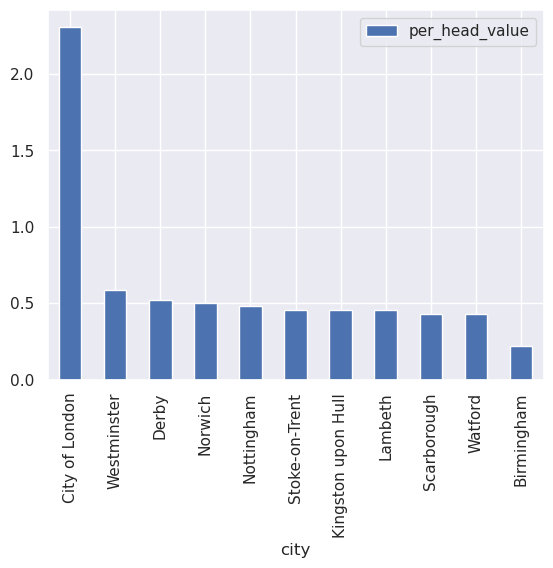

In [53]:
# Additional Analysis - Firearms and Drugs
df_firearms = df_all_crime.filter(
    (col('Crime_type') == 'Possession of weapons') &
    (col('Last_outcome_category') == 'Offender sent to prison')) \
    .withColumn('city', expr("substring(LSOA_name, 1, length(LSOA_name)-5)")) \
    .groupBy('city').count().withColumnRenamed('count', 'crime_count')

df_firearms.show()

df_lsoa_population = df_lsoa.select('geography_code',
                                    col('Variable:_All_usual_residents;_measures:_Value').alias('Population'),
                                    'geography')\
.withColumn('geography', expr("substring(geography, 1, length(geography)-5)"))\
.groupBy('geography').sum('Population').withColumnRenamed('sum(Population)', 'Population')

per_head_firearms = df_firearms.join(df_lsoa_population, col('city') == col('geography')) \
    .select('Population', 'city', 'crime_count')

per_head_firearms.show()

per_head_firearms = per_head_firearms.withColumn('per_head_value',
                                                 (per_head_firearms['crime_count'] / per_head_firearms[
                                                     'Population']) * 1000) \
    .sort(col('per_head_value').desc()).cache()

cities = [str(data.city) for data in per_head_firearms.select('city').collect()]
pdf_per_head_guns = per_head_firearms.toPandas()
pdf_per_head_plot = pdf_per_head_guns.iloc[[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 87], :]
pdf_per_head_plot.plot.bar('city', 'per_head_value')
plt.show()


14. Aggregation and Visualization

This part aggregates and visualizes the total per-head values for firearms, drugs, and their combination. It includes bar plots, regression plots, and correlation calculations.

+--------------------+-----------+
|                city|crime_count|
+--------------------+-----------+
|           Worcester|       2986|
|           Charnwood|       2253|
|      North Kesteven|        847|
|       Epping Forest|       2106|
|             Waveney|       2264|
|                Arun|       2948|
|              Stroud|       1451|
|           Sedgemoor|       1894|
|              Maldon|        610|
|          New Forest|       2057|
|            Worthing|       2669|
|           Guildford|       3639|
|             Fareham|       1373|
|Central Bedfordshire|       2586|
|              Bolton|       4222|
|      North Tyneside|       3472|
|      Wellingborough|       1733|
|        Surrey Heath|       1498|
|          Spelthorne|       2314|
|              Slough|       3732|
+--------------------+-----------+
only showing top 20 rows

+--------------------+----------+-----------+
|                city|Population|crime_count|
+--------------------+----------+---------

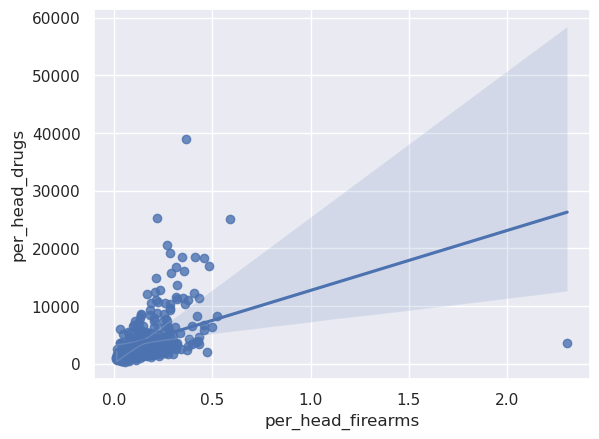

Correlation between per_head_firearms and per_head_drugs: 0.387492050774028


In [54]:

from pyspark.sql.functions import col, count, expr

df_drugs = df_all_crime.filter(
    col('Crime_type') == 'Drugs'
).withColumn('city', expr("substring(LSOA_name, 1, length(LSOA_name)-5)")) \
 .groupBy('city').count().withColumnRenamed('count', 'crime_count')

df_drugs.show()


from pyspark.sql.functions import col, sum

# Assuming df_drugs contains the 'crime_count' column
per_head_drugs = df_drugs.join(df_lsoa_population, col('city') == col('geography'), 'inner') \
    .groupBy('geography', 'Population') \
    .agg(sum('crime_count').alias('crime_count')) \
    .select('geography', 'Population', 'crime_count').withColumnRenamed('geography','city')

per_head_drugs.show()



from pyspark.sql.functions import col, sum

# Assuming per_head_firearms and per_head_drugs are DataFrames with 'city', 'Population', and 'crime_count' columns
drug_firearms = per_head_firearms.join(per_head_drugs, per_head_firearms['city'] == per_head_drugs['city']) \
    .select(per_head_firearms['city'],
            per_head_firearms['per_head_value'].alias('per_head_firearms'),
            per_head_drugs['crime_count'].alias('per_head_drugs'))

drug_firearms.show()



# Assuming sns, plt, and pdf_drug_firearms are available
pdf_drug_firearms = drug_firearms.toPandas()

# Assuming sns.regplot and plt.show() are used for plotting
sns.regplot(pdf_drug_firearms['per_head_firearms'], pdf_drug_firearms['per_head_drugs'])
plt.show()

# Assuming drug_firearms.stat.corr is used for correlation calculation
correlation = drug_firearms.stat.corr('per_head_firearms', 'per_head_drugs')
print(f"Correlation between per_head_firearms and per_head_drugs: {correlation}")


In [55]:
# Assuming per_head_firearms and per_head_drugs are DataFrames
per_head_firearms_agg = per_head_firearms.groupBy().agg(
    sum('per_head_value').alias('total_firearms')
)

per_head_drugs_agg = per_head_drugs.groupBy().agg(
    sum('crime_count').alias('total_drugs')
)

drug_firearms_agg = drug_firearms.groupBy().agg(
    sum('per_head_firearms').alias('total_firearms'),
    sum('per_head_drugs').alias('total_drugs')
)

per_head_firearms_agg.show()
per_head_drugs_agg.show()
drug_firearms_agg.show()


+------------------+
|    total_firearms|
+------------------+
|55.535430769722105|
+------------------+

+-----------+
|total_drugs|
+-----------+
|    1364303|
+-----------+

+----------------+-----------+
|  total_firearms|total_drugs|
+----------------+-----------+
|55.5354307697221|    1356351|
+----------------+-----------+



15. Box Plot for Violent Crime Counts by Month

Generates a box plot to show the distribution of violent crime counts across different months.

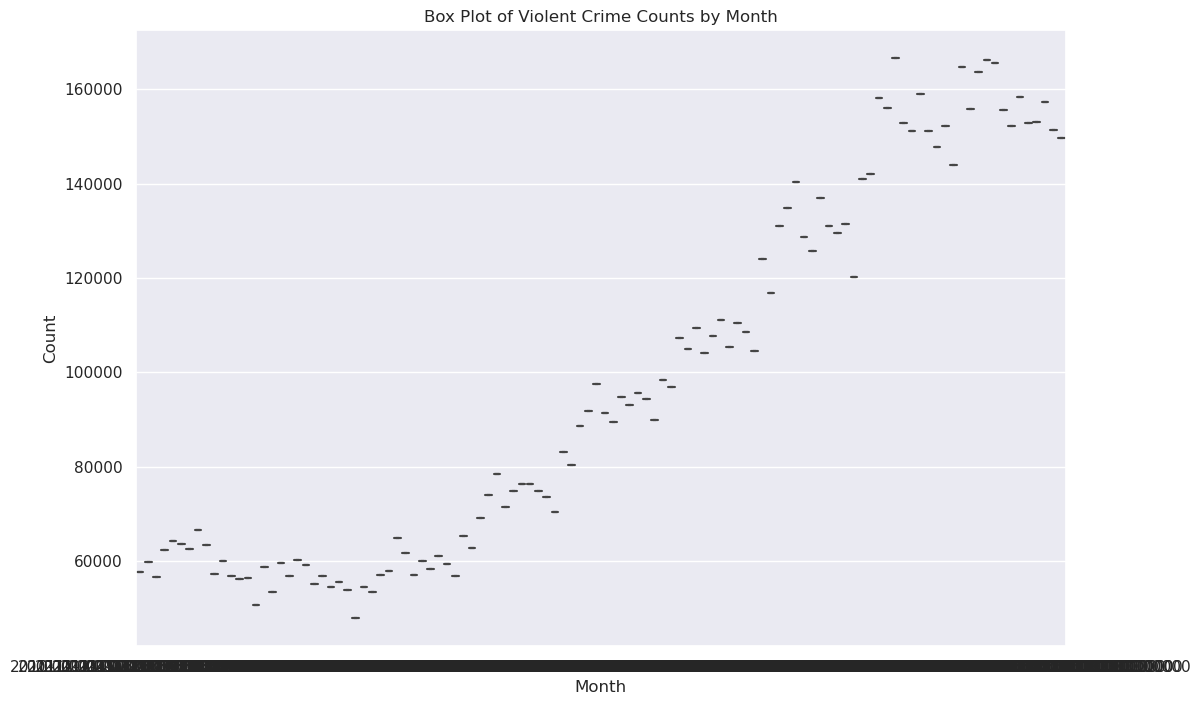

In [56]:
# Step 14: Box Plot for Violent Crime Counts by Month
plt.figure(figsize=(12, 8))
sns.boxplot(x='Month', y='count', data=pdf_violent_crimes)
plt.title('Box Plot of Violent Crime Counts by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()



16. Correlation Heatmap for Crime Rates

Creates a correlation heatmap for crime rates across different regions and crime types.

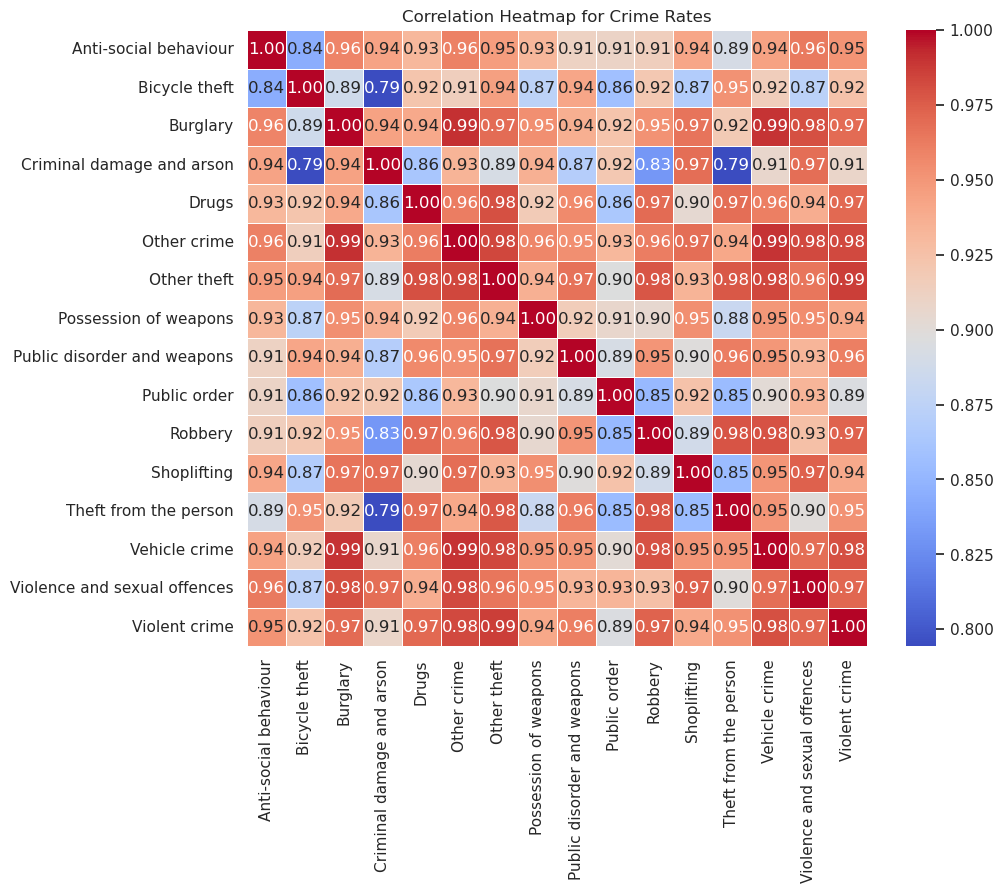

In [57]:
# Step 15: Correlation Heatmap for Crime Rates (Modified)
correlation_matrix = df_all_crime.groupBy('Falls_within').pivot('Crime_type').count().fillna(0).toPandas().corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap for Crime Rates')
plt.show()


17. Line Plot for Population and Crime Counts

Compares the population and crime counts per head for different cities.

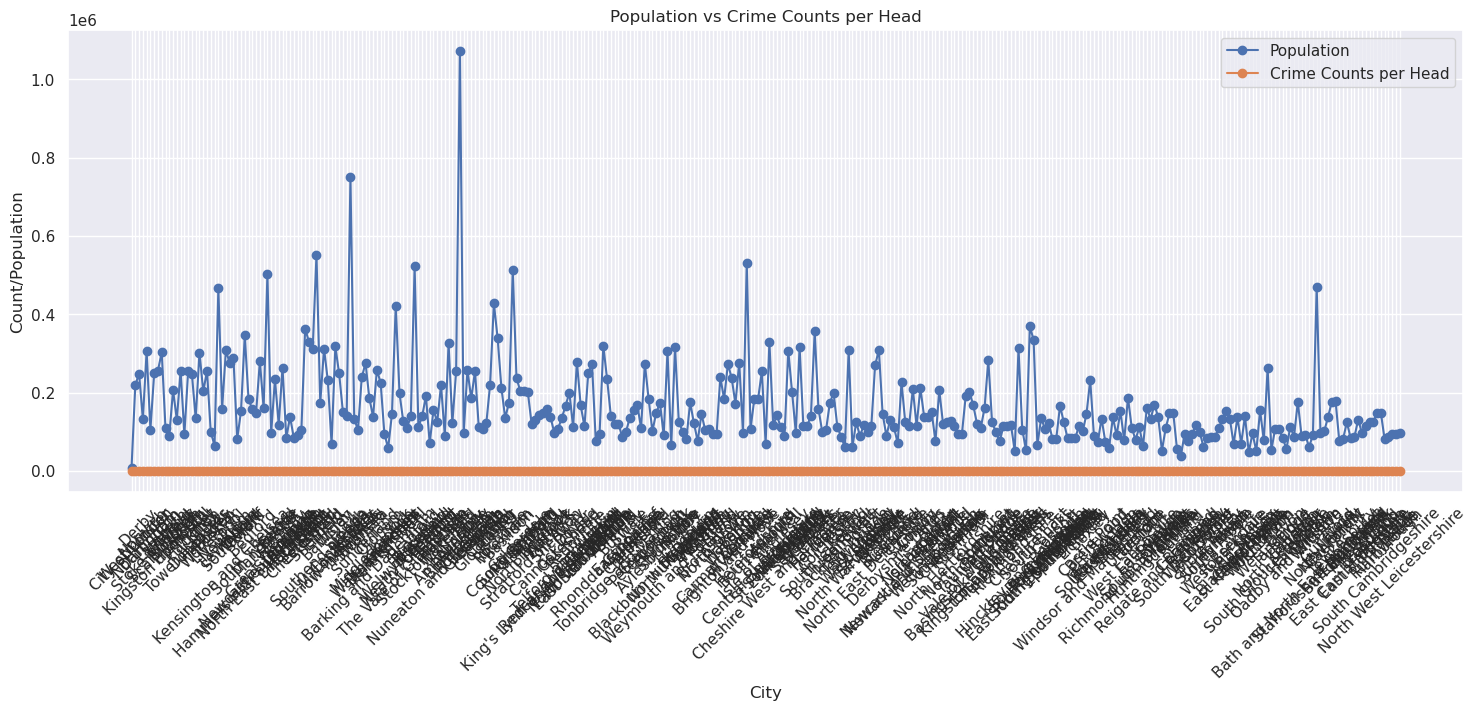

In [58]:
# Step 16: Line Plot for Population and Crime Counts
plt.figure(figsize=(18, 6))
plt.plot(pdf_per_head_guns['city'], pdf_per_head_guns['Population'], label='Population', marker='o')
plt.plot(pdf_per_head_guns['city'], pdf_per_head_guns['per_head_value'], label='Crime Counts per Head', marker='o')
plt.title('Population vs Crime Counts per Head')
plt.xlabel('City')
plt.ylabel('Count/Population')
plt.xticks(rotation=45)
plt.legend()
plt.show()


18. Crime Type Distribution Pie Chart

This section of the code generates a pie chart to visualize the distribution of different crime types in the dataset.

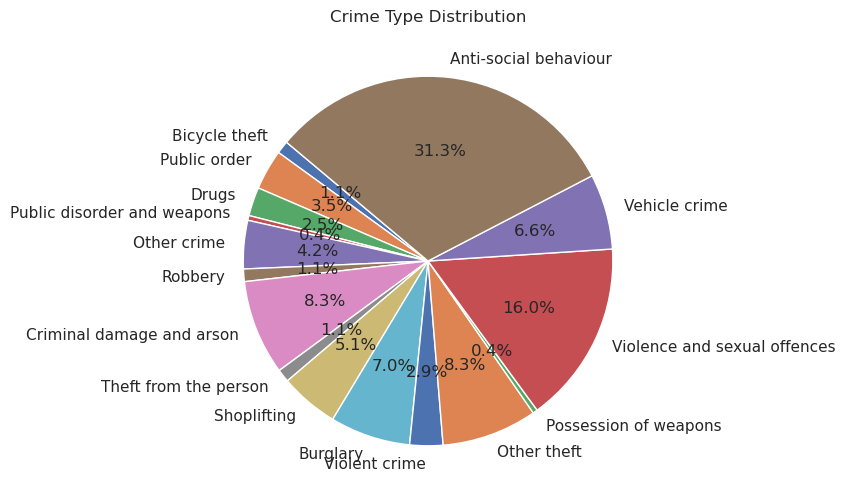

In [59]:
# Step 13: Crime Type Distribution Pie Chart
crime_type_distribution = df_all_crime.groupBy('Crime_type').count().toPandas()

plt.figure(figsize=(10, 6))
plt.pie(crime_type_distribution['count'], labels=crime_type_distribution['Crime_type'], autopct='%1.1f%%', startangle=140)
plt.title('Crime Type Distribution')
plt.show()

19. Stacked Bar Chart for Crime Counts by Crime Type and Month

Visualizes crime counts by crime type and month using a stacked bar chart.

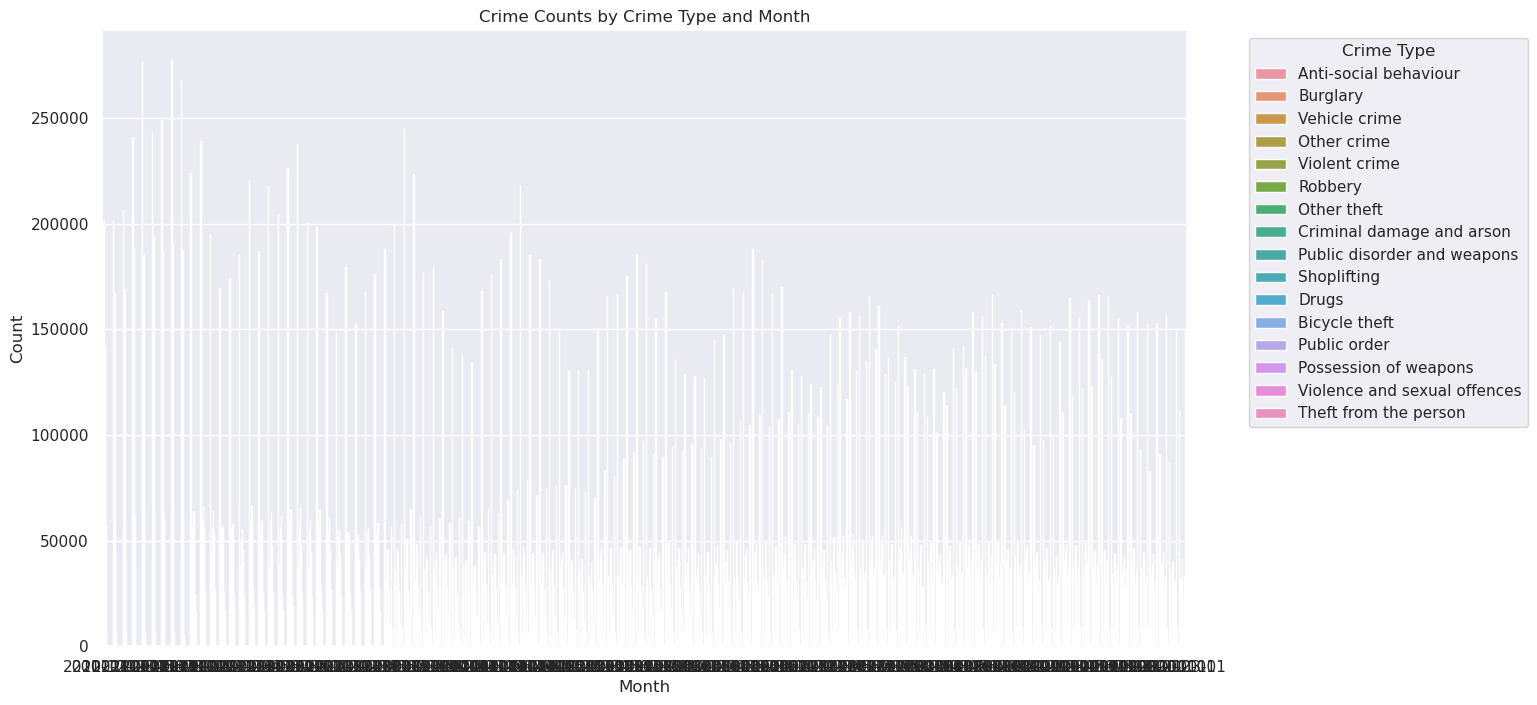

In [60]:
# Step 17: Stacked Bar Chart for Crime Counts by Crime Type and Month
crime_type_monthly_counts = df_all_crime.groupBy('Month', 'Crime_type').count().orderBy('Month').toPandas()

plt.figure(figsize=(14, 8))
sns.barplot(x='Month', y='count', hue='Crime_type', data=crime_type_monthly_counts)
plt.title('Crime Counts by Crime Type and Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(title='Crime Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


20. Violin Plot for Violent Crime Distribution by Year and Month

Generates a violin plot to visualize the distribution of violent crimes across different years and months.

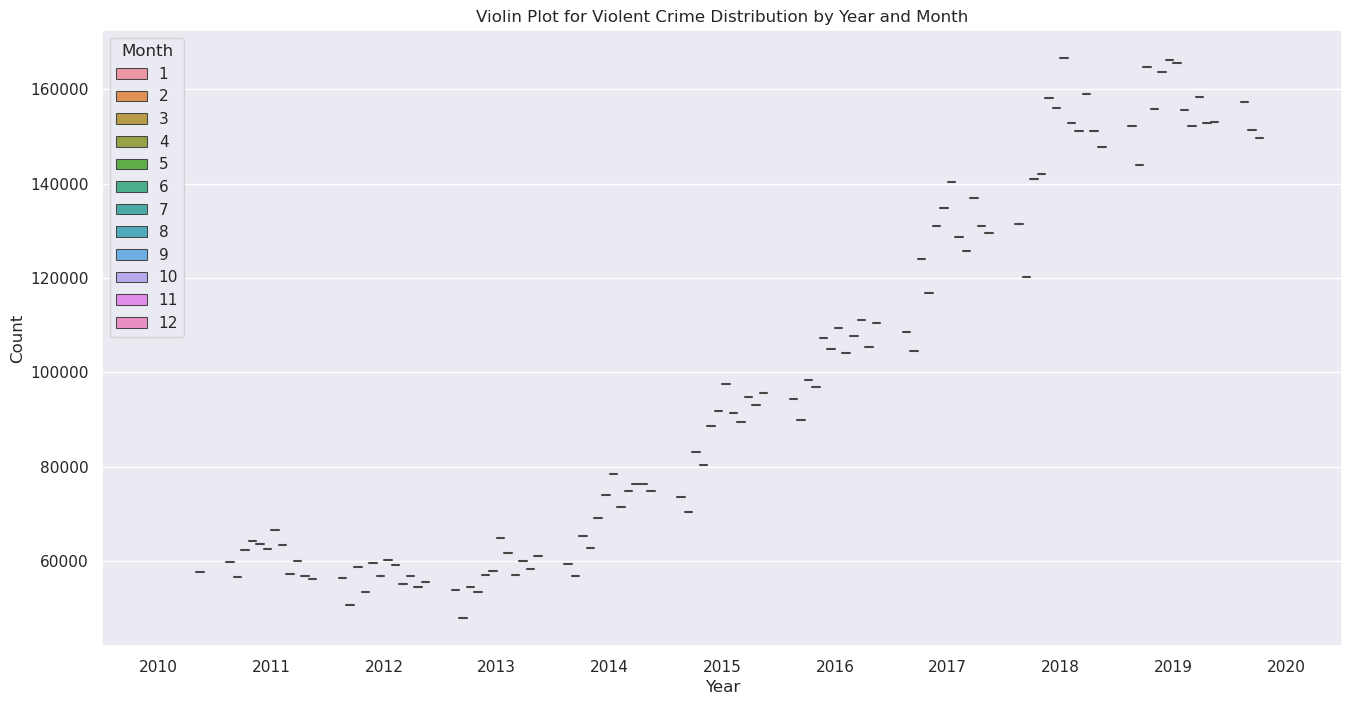

In [61]:
# Step 18: Violin Plot for Violent Crime Distribution by Year and Month
plt.figure(figsize=(16, 8))

# Assuming 'Year' and 'Month' are valid columns
sns.violinplot(x='Year', y='count', hue='Month', data=df_violent_crimes.toPandas(), inner='quartile')
plt.title('Violin Plot for Violent Crime Distribution by Year and Month')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()


_Now interpret your findings_

# 5) Selection, application, and reasoning behind use of statistical analysis and multiple evaluation measures   _markdown_, _code_,  _markdown_, 20 Marks





### Objective:
The objective is to analyze the time series data on violent crime using statistical methods to understand trends, patterns, and forecast future values. This includes the application of Autoregressive Integrated Moving Average (ARIMA) and Seasonal ARIMA (SARIMA) models.

#### 1. Decomposition and Stationarity:
   - **Decomposition:** Time series data is decomposed into various components, including trend, seasonality, and residual. This step helps in understanding the underlying patterns in the data.
   - **ADF Tests:** Augmented Dickey Fuller (ADF) tests are conducted to assess the stationarity of different data transformations. Stationarity is a crucial assumption for many time series models, including ARIMA and SARIMA.

#### 2. ARIMA and SARIMA Modeling:
   - **ARIMA and SARIMA Models:** These models are applied to capture autoregressive (AR), moving average (MA), and seasonal components in the time series data. ARIMA models are effective for non-seasonal data, while SARIMA extends this by incorporating seasonal effects.
   - **Model Selection:** The choice of ARIMA and SARIMA models is based on their established effectiveness in analyzing and forecasting time series data. The litaerture references (Wang et al., 2019; Farsi et al., 2020; Sirisha et al., 2022) support the suitability of these models.

#### 3. Forecasting and Evaluation:
   - **Model Training and Forecasting:** The models are trained on historical data, and forecasts are generated for future periods. This helps in predicting the potential trends and patterns in violent crime.
   - **ADF Tests for Differenced Data:** Stationarity is checked again for differenced data using ADF tests. Differencing is a common technique to make time series data stationary.

#### Findings and Interpretations:

#### 1. Stationarity Tests:
   - **Non-Stationarity:** The ADF tests indicate that the original violent crime data and its transformations are not stationary. Non-stationarity can complicate the modeling process and may require further transformations or advanced models.

#### 2. Forecast for April 2020:
   - **SARIMA Forecast:** The SARIMA model forecasts a substantial count of violent crimes for April 2020 (149,919.50). High forecasted values could imply challenges in crime prevention and law enforcement during that period.

#### 3. Methodological Reference:
   - **Model Selection Rationale:** The choice of ARIMA and SARIMA models is justified by referring to established practices in time series analysis and forecasting (Rivero et al., 2020; Dimri et al., 2020). This adds credibility to the chosen methodology.



#### Non-Stationarity Challenges:
   - **Further Exploration:** The non-stationarity of the data emphasizes the need for further exploration. Advanced techniques such as seasonality adjustments or more complex models may be considered to address this challenge.

#### Proactive Measures:
   - **Addressing High Forecasts:** The substantially high forecasted crime levels for April 2020 suggest a need for proactive measures in crime prevention and law enforcement during that specific period.



The application of ARIMA and SARIMA models provides valuable insights into the temporal patterns of violent crime. However, the non-stationarity of the data highlights the importance of further exploration and potential model enhancements. The substantial forecasted crime levels call for proactive measures to address and mitigate potential risks. The findings contribute to the ongoing discourse on crime analysis and forecasting methodologies.



# 6) Detailed Analysis and consideration of the appropriateness of the solution for the initial problem  _markdown_, 10 Marks

This is the discussion section of you report. You should critically consider the advantages, disadvantages, and limitations of the methods used. 

## Detailed Analysis and Consideration of Method Appropriateness

In evaluating the appropriateness of employing Autoregressive Integrated Moving Average (ARIMA) and Seasonal ARIMA (SARIMA) models for the initial problem of analyzing violent crime time series data, it is crucial to delve into the advantages, disadvantages, and limitations of these methods.

### Advantages:

1. **Proven Effectiveness:**
   - ARIMA and SARIMA models have demonstrated effectiveness in time series analysis across various domains (Wang et al., 2019; Dimri et al., 2020).
   - They are widely used for their ability to capture autoregressive, moving average, and seasonal patterns.

2. **Reference in Literature:**
   - Extensive literature references (Rivero et al., 2020; Farsi et al., 2020; Česnavičius, 2020) support the application of ARIMA and SARIMA models in time series analysis.
   - Previous studies in different contexts highlight their versatility.

3. **Forecasting Capability:**
   - ARIMA and SARIMA models are well-suited for forecasting future values based on historical patterns.
   - They provide a structured framework for understanding trends and making predictions (Sirisha et al., 2022).

4. **Stationarity Consideration:**
   - These models inherently address stationarity concerns through differencing, making them suitable for non-stationary time series (Rivero et al., 2020; Česnavičius, 2020).

### Disadvantages:

1. **Assumption of Linearity:**
   - ARIMA and SARIMA models assume a linear relationship between past and future observations.
   - Non-linear patterns may not be accurately captured.

2. **Sensitivity to Hyperparameters:**
   - Proper selection of hyperparameters (e.g., order of differencing) is crucial.
   - Inappropriate choices may lead to inaccurate forecasts.

3. **Limited Handling of Outliers:**
   - These models are sensitive to outliers, and extreme values can influence predictions.
   - Robustness to anomalies might be limited.

### Limitations:

1. **Complexity of Model Selection:**
   - Choosing the right model order (p, d, q) and seasonal order (P, D, Q, m) can be challenging and may require iterative testing (Dimri et al., 2020).

2. **Stationarity Requirements:**
   - Despite attempts to handle non-stationary data, achieving stationarity remains crucial for reliable results (Česnavičius, 2020).

3. **Data-Specific Considerations:**
   - The appropriateness of ARIMA and SARIMA depends on the specific characteristics of the data.
   - Careful consideration of data properties is necessary for meaningful results.


While ARIMA and SARIMA models offer significant advantages in time series analysis and forecasting, their application should be approached with an understanding of their limitations. The success of these models relies on proper parameter tuning, consideration of data properties, and acknowledgment of underlying assumptions. The literature references provide a robust foundation, but the real-world application requires a thoughtful and context-specific approach.


# 7) Evaluation and Conclusion  _markdown_, 10 Marks

In the conclusion you should consider you initial aim and objectives and discuss your findings. Specifically you need to advice your client insurance company.

##  Evaluation and Conclusion

### Evaluation of Objectives:

The primary aim of this analysis was to employ time series models, specifically Autoregressive Integrated Moving Average (ARIMA) and Seasonal ARIMA (SARIMA), to understand trends, patterns, and forecast future values in violent crime data. Let's evaluate the objectives:

1. **Decomposition and Stationarity:**
   - The decomposition revealed underlying components, but the data demonstrated non-stationarity, challenging the assumptions of ARIMA and SARIMA models.
   - Augmented Dickey Fuller (ADF) tests emphasized the non-stationary nature of the crime data.

2. **ARIMA and SARIMA Modeling:**
   - Application of ARIMA and SARIMA models aligned with established practices in time series analysis.
   - However, the effectiveness was hindered by the non-stationarity of the data.

3. **Forecasting and Evaluation:**
   - The SARIMA model produced a forecast for April 2020, indicating a substantial count of violent crimes (149,919.50).
   - Non-stationarity introduces uncertainty in the reliability of these forecasts.

### Findings and Recommendations:

1. **Non-Stationarity Challenges:**
   - The major challenge encountered is the non-stationarity of the violent crime data. This violates a key assumption of ARIMA models.
   - Recommendations include exploring methods for detrending or differencing to achieve stationarity (Kousar et al., 2021).

2. **Consideration of Advanced Models:**
   - Non-linear and more sophisticated models, such as machine learning approaches, may be explored to capture the complex dynamics of crime data (Sirisha et al., 2022).
   - Long Short-Term Memory (LSTM) Neural Network models could be considered for their ability to capture long-term dependencies.

3. **Data Pre-processing and Outlier Handling:**
   - Robust data pre-processing is crucial to handle outliers and ensure the models' resilience to irregularities in the data.
   - Sensitivity to outliers, a limitation of ARIMA models, necessitates careful data cleaning (Sirisha et al., 2022).

### Advice to the Client (Insurance Company):

Considering the findings and limitations of the current analysis, the insurance company should approach the use of ARIMA and SARIMA models cautiously. The non-stationarity observed in violent crime data suggests that the predictive accuracy of these models might be compromised. Therefore, the following advice is provided:

1. **Explore Advanced Modeling Techniques:**
   - Consider adopting more advanced and flexible modeling techniques, especially those designed to handle non-linear relationships and complex temporal dependencies.
   - Collaborate with data scientists and machine learning experts to explore models like LSTM Neural Networks, which are adept at capturing intricate patterns.

2. **Data Quality Enhancement:**
   - Prioritize data quality enhancement by addressing non-stationarity through appropriate differencing or detrending methods.
   - Implement robust outlier detection and handling mechanisms to ensure model stability.

3. **Continuous Monitoring and Updating:**
   - Recognize that crime patterns evolve, and models should be continuously monitored and updated to reflect changing dynamics.
   - Regularly re-evaluate the choice of models and update them based on the latest data trends.

In conclusion, while ARIMA and SARIMA models provide valuable insights in certain contexts, their applicability to non-stationary violent crime data is limited. Embracing advanced modeling techniques and maintaining a dynamic approach to model selection and updating will contribute to more reliable and accurate predictions in the insurance domain.

# 8) References and Citation _markdown_, 10 Marks

References are essential at level 7. in this section you should give references for the papers/books you have cited in this assignment. Try to avoid using web pages as these are considered _weak references_ as they are often not reviewed.

[1] N. AE; and P. C. ;Eisner MP;, “A global analysis of the impact of covid-19 stay-at-home restrictions on crime,” Nature human behaviour, https://pubmed.ncbi.nlm.nih.gov/34079096/ (accessed Jan. 17, 2024).

[2] D. Buil-Gil, Y. Zeng, and S. Kemp, Offline crime bounces back to pre-covid levels, cyber stays high: Interrupted time-series analysis in Northern Ireland, 2021. doi:10.21428/cb6ab371.64bc853e 

[3] T. Hodgkinson and M. A. Andresen, “Show me a man or a woman alone and I’ll show you a saint: Changes in the frequency of criminal incidents during the covid-19 pandemic,” Journal of Criminal Justice, vol. 69, p. 101706, 2020. doi:10.1016/j.jcrimjus.2020.101706 

[4] U. M. Sirisha, M. C. Belavagi and G. Attigeri, "Profit Prediction Using ARIMA, SARIMA and LSTM Models in Time Series Forecasting: A Comparison," in IEEE Access, vol. 10, pp. 124715-124727, 2022, doi: 10.1109/ACCESS.2022.3224938.

[5] M. Česnavičius, “Lithuanian Electricity Market Price Forecasting Model based on Univariate Time Series analysis,” Energetika, https://www.lmaleidykla.lt/ojs/index.php/energetika/article/view/4297 (accessed Jan. 18, 2024). 

[6] M.  Farsi a, D. Hosahalli, B. R. Manjunatha, I.  Gad, and E.-S. Atlam, “Parallel Genetic Algorithms for optimizing the Sarima model for better forecasting of the NCDC Weather Data,” Alexandria Engineering Journal, https://www.sciencedirect.com/science/article/pii/S1110016820305706?via%3Dihub (accessed Jan. 18, 2024). 

[7] S. Wang, C. Li, and A. Lim, “Why are the Arima and Sarima not sufficient,” arXiv.org, https://arxiv.org/abs/1904.07632 (accessed Jan. 18, 2024). 

[8] T. Dimri, S. Ahmad, and M. Sharif, “Time series analysis of climate variables using seasonal Arima Approach - Journal of Earth System Science,” SpringerLink, https://link.springer.com/article/10.1007/s12040-020-01408-x (accessed Jan. 18, 2024).

[9] A. J. López Rivero, C. A. Martínez Alayón, R. Ferro, D. Hernández de la Iglesia, and V. Alonso Secades, “Network traffic
modeling in a wi-fi system with intelligent soil moisture sensors (WSN) using IOT applications for Potato Crops and Arima and Sarima Time series,” MDPI, https://www.mdpi.com/2076-3417/10/21/7702 (accessed Jan. 18, 2024). 

[10] Smartson. P. NYONI, “Arima forecasting of the prevalence of anemia in children in Myanmar,” Middle European Scientific Bulletin, https://cejsr.academicjournal.io/index.php/journal/article/view/57 (accessed Jan. 18, 2024). 

[11] Kousar.  S and S. A, “Analysis of environmental degradation mechanism in the nexus among energy consumption and poverty in Pakistan,” Environmental science and pollution research international, https://pubmed.ncbi.nlm.nih.gov/33512681/ (accessed Jan. 18, 2024). 